# Проект: вариант 2

## Задание 1. A/B–тестирование

### Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

##### Импортируем модули и библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize": (16, 8)}) # устанавливаем размер графиков
import plotly.express as px
import scipy.stats as ss
from statsmodels. stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp  
import pingouin as pg

##### Считываем данные

In [2]:
# Устанавливаем библиотеки для скачивания файлов с url
import requests
from urllib.parse import urlencode

# функция для скачивания файлов с Яндекс Диска
def download_yandex_disc(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return download_url

In [3]:
# Скачиваем файлы
groups = pd.read_csv(download_yandex_disc('https://disk.yandex.ru/d/UhyYx41rTt3clQ'),  sep = ';')
group_add = pd.read_csv(download_yandex_disc('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep = ',')
active_studs = pd.read_csv(download_yandex_disc('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep = ',')
checks = pd.read_csv(download_yandex_disc('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'),  sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


##### Добавим датафрейм group_add к основному датафрейму groups

In [4]:
full_groups = pd.concat([groups, group_add])

##### Изучим данные

In [5]:
full_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
full_groups.shape

(74576, 2)

In [7]:
full_groups.nunique() #Значения уникальны

id     74576
grp        2
dtype: int64

In [8]:
full_groups.isna().sum() #Нет пропущенных значений

id     0
grp    0
dtype: int64

In [9]:
full_groups.groupby('grp').size() #смотрим на количество в тестовой и контрольной группе, количество человек 
# в тестовой группе в 4 раза больше, чем в контрольной

grp
A    14693
B    59883
dtype: int64

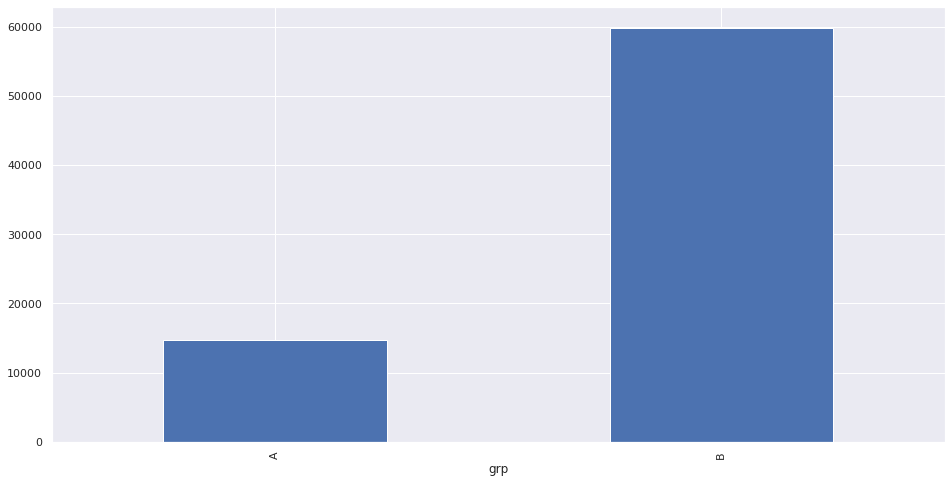

In [10]:
full_groups.groupby('grp').size().plot.bar()

In [11]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
active_studs.shape

(8341, 1)

In [13]:
active_studs.nunique() #Значения уникальны

student_id    8341
dtype: int64

In [14]:
active_studs.isna().sum() #Нет пропущенных значений

student_id    0
dtype: int64

In [15]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [16]:
checks.shape

(541, 2)

In [17]:
checks.nunique() #Значения id уникальны

student_id    541
rev            39
dtype: int64

In [18]:
checks.isna().sum() #Нет пропущенных значений

student_id    0
rev           0
dtype: int64

##### Проверим, все ли платящие пользователи были активными. Для этого объединим таблицы checks и active_studs.

In [19]:
active_paying_studs = checks.merge(active_studs, on='student_id')

In [20]:
active_paying_studs.shape

(392, 2)

In [21]:
checks.shape[0]-active_paying_studs.shape[0]

149

##### Как видим, 149 чел совершили оплату, не будучи активными в день эксперимента. Возможно, они пользовались альтернативными  способами оплаты. Их мы не будем включать в исследование.

##### Объединим таблицу с принадлежностью к группе и таблицу с платежами активных пользователей.

In [22]:
paying_studs = active_paying_studs.merge(groups, left_on = 'student_id', right_on = 'id')

In [23]:
paying_studs.head()

,student_id,rev,id,grp
0,1627,990.0000,1627,A
1,100300,990.0000,100300,B
2,108270,290.0000,108270,B
3,264473,1900.0001,264473,B
4,274352,690.0000,274352,B


In [24]:
paying_studs = paying_studs.drop('id', axis=1) # уберем дублирующийся столбец

In [25]:
paying_studs.shape

(391, 3)

##### Объединим таблицу с принадлежностью к группе и таблицу с  активными пользователями.

In [26]:
active_groups = active_studs.merge(groups, left_on = 'student_id', right_on = 'id')

In [27]:
active_groups.head()

,student_id,id,grp
0,581585,581585,A
1,3276743,3276743,B
2,4238589,4238589,A
3,4475369,4475369,B
4,5481015,5481015,B


In [28]:
active_groups.shape

(8328, 3)

In [29]:
active_groups = active_groups.drop('id', axis=1) # уберем дублирующийся столбец

In [30]:
active_groups.isna().sum()  #Нет пропущенных значений

student_id    0
grp           0
dtype: int64

##### Объединим таблицу с активными польхователями и таблицу с платящими пользователями (с данными по разпределению между группами)

In [31]:
final_df = active_groups.merge(paying_studs, how = 'left', on = ['student_id', 'grp']).fillna(0)

In [32]:
final_df.head()

,student_id,grp,rev
0,581585,A,0.0
1,3276743,B,0.0
2,4238589,A,0.0
3,4475369,B,0.0
4,5481015,B,0.0


### Обозначим целевую метрику - конверсия в оплату.  H0 - значeния конверсии у контрольной и целевой группы не различаются, H1 - значения метрики значимо различаются. 

### 1.1. Конверсия  в оплату

In [33]:
 final_df.grp.value_counts(normalize=True).mul(100) # соотношение участников в контрольной и тестовой группе

B    81.568204
A    18.431796
Name: grp, dtype: float64

##### Создадим столбец с информацией, была ли осуществлена оплата.

In [34]:
final_df['payment'] = final_df.rev>0

In [35]:
final_df.head()

,student_id,grp,rev,payment
0,581585,A,0.0,False
1,3276743,B,0.0,False
2,4238589,A,0.0,False
3,4475369,B,0.0,False
4,5481015,B,0.0,False


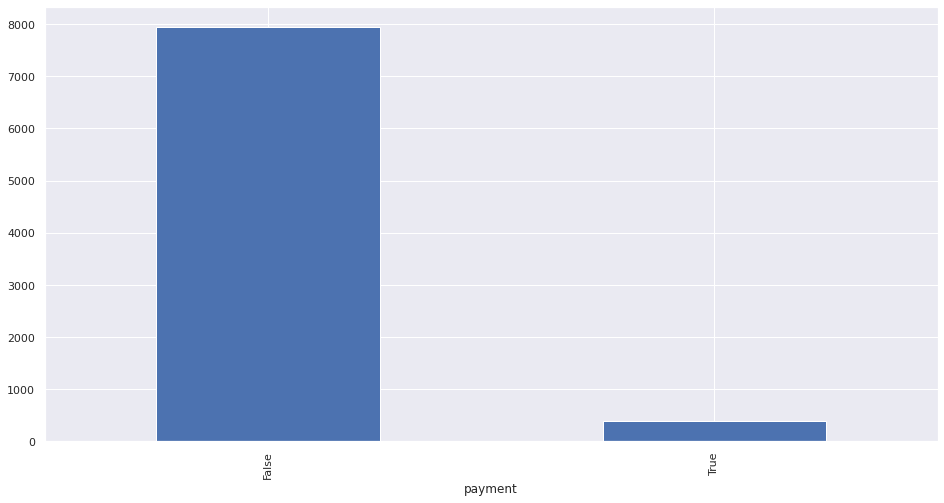

In [38]:
final_df.groupby('payment').size().plot.bar()

In [ ]:
pd.crosstab(final_df.grp, final_df.payment)

In [ ]:
CR_A = round(78/(1457+78)*100, 2) # конверсия в покупку контрольной группы
CR_A

In [ ]:
CR_B = round(313/(6480+313)*100, 2) # конверсия в покупку целевой группы
CR_B

##### Конверсия у тестовой группы меньше. Выясним, значимые ли это различия. Поскольку факт оплаты - дискретная переменная, применяем хи-квадрат.

In [ ]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(final_df.grp, final_df.payment))
stat, p

In [ ]:
prob = 0.95
alpha = 1 - 0.95
p = 0.46803677583199144
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

### P-value = 0,47, что значительно больше 0,05. Нулевую гипотезу о том, что значения конверсии в оплату  контрольной и целевой группе не различаются значимо, не отклоняем.

### 1.2.  Прокси-метрика - средний чек на платящего пользователя. H0 - средний чек в контрольной и тестовой группе не отличается. H1 - средний чек статистически значимо отличается.

##### Формируем отдельные датасеты для контрольной и тестовой группы, только для оплаченных данных.

In [39]:
final_df_A = final_df[final_df['grp']=='A'].query('payment == True')
final_df_B= final_df[final_df['grp']=="B"].query('payment == True')

In [40]:
final_df_A.groupby('grp', as_index = False).agg({'rev': 'mean'}).round() # Рассчтаем средний чек в группе А.

,grp,rev
0,A,934.0


In [41]:
final_df_B.groupby('grp', as_index = False).agg({'rev': 'mean'}).round() # Рассчтаем средний чек в группе B. Он выше.

,grp,rev
0,B,1256.0


##### Данные непрерывные, построим гистрограммы и проверим на гомоскедатичность дисперсий и нормальность.

In [50]:
 pg.homoscedasticity(data=final_df, dv='rev', group='grp') #дисперсии однородны

,W,pval,equal_var
levene,1.423391,0.23288,True


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


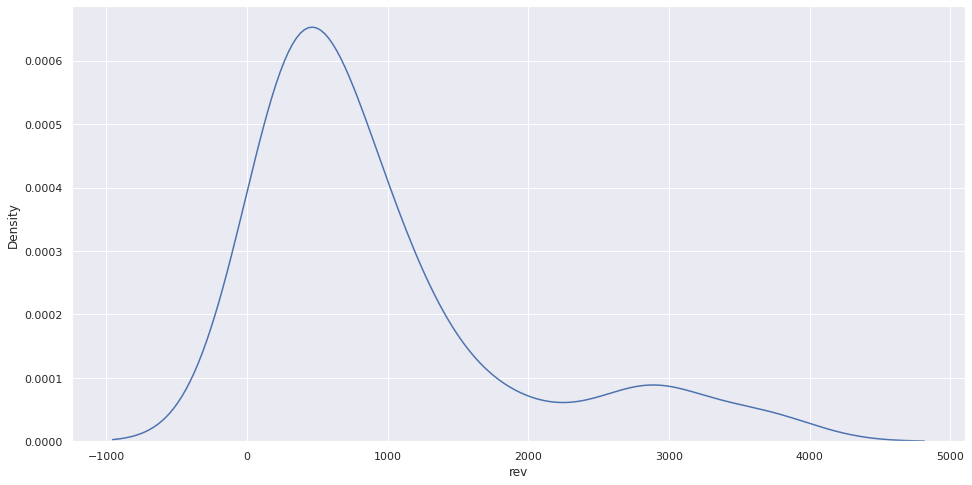

In [51]:
sns.distplot(final_df_A.rev, hist=False)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


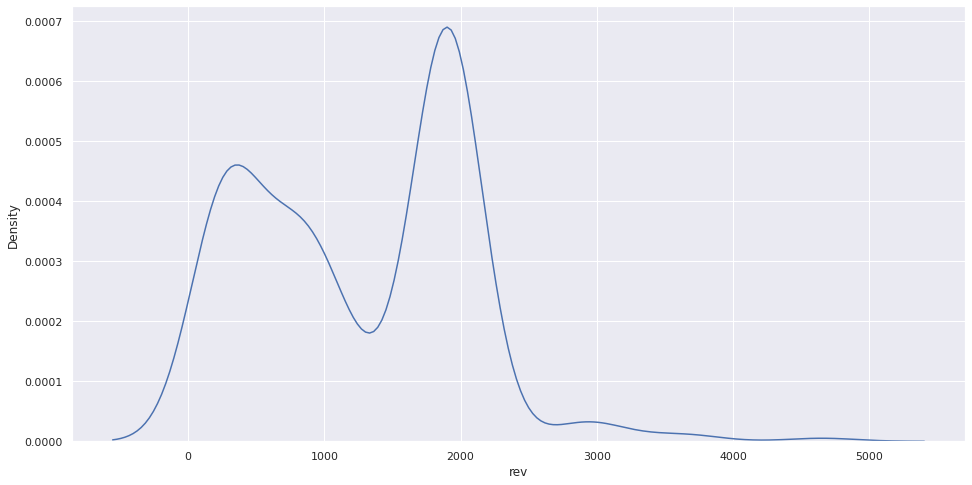

In [52]:
sns.distplot(final_df_B.rev, hist=False)

In [53]:
ss.normaltest(final_df_A.rev) # Отклоняем нулевую гипотезу о нормальности данных.

NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)

In [54]:
ss.normaltest(final_df_B.rev) # Отклоняем нулевую гипотезу о нормальности данных.

NormaltestResult(statistic=7.022269699078301, pvalue=0.029863005181946005)

In [56]:
ss.normaltest(np.log(final_df_A.rev))  # Пробуем пролагарифмировать данные, все равно отклоняем нулевую гипотезу о нормальности данных.

NormaltestResult(statistic=7.991539919189246, pvalue=0.018393278875655467)

In [48]:
ss.normaltest(np.log(final_df_B.rev))  # Пробуем пролагарифмировать данные, все равно отклоняем нулевую гипотезу о нормальности данных.

NormaltestResult(statistic=86.64991674044852, pvalue=1.5283036528109365e-19)

In [67]:
p = ss.ttest_ind(final_df_A.rev, final_df_B.rev)  #  Так как размер выборок достаточно большой, то можно 
#принебречь тем, что распределение в выборках отличается от нормального, и использовать t-тест.
print('p-value:', p[1])

p-value: 0.001999178025210522


In [66]:
prob = 0.95
alpha = 1 - 0.95
p = p[1]
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


#####  Средний чек платящего пользователя изменился статистически значимо (p-value = 0.002), мы не можем принять нулевую гипотезу о том, что новый мезанизм не влияет на величину показателя.

### Подведем итог. Мы проанализировали конверсию и средний чек у контрольной и тестовой группы. 
### Конверсия ниже у тестовой группы (5,08% у контрольной, 4,61% у тестовой), однако значения не ститистически значимые.
### Средний чек выше у тестовой группы (934 руб у контрольной, 1256 руб у тестовой), и эти различия статистически значимые.
### На основе полученных данных однозначно нельзя сделать вывод о целесообраности внедрения новой механики оплаты. Это решение требует дальнейшей проработки.

## Задание 2. SQL

### 2.1 Очень усердные ученики. 
### Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной". Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин. Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

In [ ]:
import pandahouse as ph # Подключаем библиотеку для взаимодействия с Clickhouse

In [ ]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',  # Подключаемся к Clickhouse
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [ ]:
query_1 = """
SELECT COUNT(st_id) as count_good_students FROM
(SELECT st_id, sum(correct) as correct_answers, toStartOfMonth(timest) as month
from default.peas  
GROUP BY st_id, toStartOfMonth(timest)
HAVING correct_answers >=20) """

q_peas = ph.read_clickhouse(query=query_1, connection=connection_default)
q_peas

### Итого 136 очень усердных учеников.

### 2.2 Оптимизация воронки. Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты. Необходимо в одном запросе выгрузить следующую информацию о группах пользователей: ARPU, ARPAU, CR в покупку, СR активного пользователя в покупку, CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [ ]:
query_2 = """
SELECT test_grp,
round(sum(money)/ count(DISTINCT st_id), 2) as ARPU, 
round(sum(money)/ countIf(st_id, sum_correct>10), 2) as ARPAU,
round((uniqExactIf(st_id, money > 0)/COUNT(DISTINCT st_id)*100), 2) as CR,
round((uniqExactIf(st_id, money > 0 and sum_correct>10)/uniqExactIf(st_id, sum_correct>10) *100), 2) as CR_active,
round((uniqExactIf(st_id, money > 0 and sum_correct_math>=2)/uniqExactIf(st_id, sum_correct_math>=2) *100), 2) as CR_math
FROM
(SELECT DISTINCT(studs.st_id) as st_id, test_grp, subject, money, sum_correct, sum_correct_math
FROM default.studs  
LEFT JOIN default.final_project_check ON studs.st_id = final_project_check.st_id
LEFT JOIN 
(SELECT
    st_id, sum(correct) as sum_correct,
            sumIf(correct, subject = 'Math') as sum_correct_math
FROM
    default.peas
GROUP BY st_id) as new_peas ON new_peas.st_id = studs.st_id) t1
GROUP BY test_grp """

q_metrics = ph.read_clickhouse(query=query_2, connection=connection_default)
q_metrics

## Задание 3. Python

### Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [ ]:
def new_metrics(groups_add):
    groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-c/Final Project/Проект_2_groups.csv', sep = ';')
    active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-c/Final Project/Проект_2_active_studs.csv')
    checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-c/Final Project/Проект_2_checks.csv', sep = ';')
    # считываем основные таблицы
    full_groups = pd.concat([groups, groups_add]) # объединяем основную таблицу по группам с дополнительной
    new_checks = checks.merge(active_studs, on='student_id') # убираем платящих, которые не были активными
    active_groups = active_studs.merge(full_groups, left_on = 'student_id', right_on = 'id') # объединяем инфо об актиности с разделением на группы
    active_groups = active_groups.drop('id', axis=1) # убраем поторяющийся столбец
    final_df = active_groups.merge(new_checks, how = 'left', on = 'student_id').fillna(0) # объединяем инфо об оплате с инфо об активности
    final_df['payment'] = final_df.rev>0 # создаем колонку с фактом оплаты
    metrics_1 = final_df.groupby('grp', as_index = False).agg({'student_id':'count', 'rev':'sum'}).round(2)\
    .rename(columns = {'student_id':'num_stud', 'rev': 'revenue'}) # создаем поля количестом и общим доходом
    metrics_2 = final_df.query('payment == True').groupby('grp', as_index = False).agg({'student_id':'count'})\
    .rename(columns = {'student_id':'paying_stud'})  # создаем колонку с количеством платящиъ пользовавтелей
    full_metrics = metrics_1.merge(metrics_2, on = 'grp') # объединяем метрики
    full_metrics['CR'] = round(full_metrics.paying_stud/ full_metrics.num_stud *100, 2) # создаем колонку с CR
    full_metrics['ARPPU'] = round(full_metrics.revenue/ full_metrics.paying_stud, 2) # создаем колонку со средним чеком платящих пользоателей
    return full_metrics 

### Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [ ]:
groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-c/Final Project/Проект_2_group_add.csv')

In [ ]:
new_metrics(groups_add)

In [ ]:
def metrics_plot(data):
    plt.subplot(1, 2, 1) # создаем графики CR и ARPPU
    sns.barplot(data=data, x = 'grp', y='CR')
    plt.subplot(1, 2, 2)
    sns.barplot(data=data, x = 'grp', y='ARPPU')

In [ ]:
data = new_metrics(groups_add)
metrics_plot(data)